In [36]:
#imports and config

import re
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "courier"
    }
)

In [37]:
#put helper functions/calculations here!

def con(x):
    """Convert to float if possible"""
    try:
        return float(x)
    except:
        return None

def adjust_typing(data):
    data = data.convert_dtypes()
    data["Plx"] = data["Plx"].apply(con)
    data["e_Plx"] = data["e_Plx"].apply(con)
    data["B-V"] = data["B-V"].apply(con)
    data["Vmag"] = data["Vmag"].apply(con)
    data["Hpmag"] = data["Hpmag"].apply(con)
    data["_Glon"] = data["_Glon"].apply(con)
    data["_Glat"] = data["_Glat"].apply(con) 
    return data

#parallax is given in milliarcseconds (mas). Following is an ordered list (same order as columns) of units:
#deg|deg|deg|deg|deg|deg|deg|deg|d|s| | | | |mag| | |deg|deg| |mas|mas/yr|mas/yr|mas|mas|mas|mas/yr|mas/yr| | | | | | | | | | |%| |mag|mag|mag|mag| |mag|mag| |mag|mag| | |mag|mag|mag| | |mag|mag|d| | | | | | | | | | | |deg|arcsec|arcsec|mag|mag| | | | | | | |mag| | | | |deg|deg
def add_dist_cols(data):
    """Adds columns related to distance, i.e. distance, standard distance error both negative and positive
        Since the standard error on the parallax does not give the same standard error for distance for both the + and -, we take both.
        Dist = 1/tan(x/1000) (x in milliarcseconds)
        e_Dist* = 1/tan((x+/-e_x)/1000) - dist
    """
    mas_to_pc = lambda x : 1/(np.tan(x/1000))
    data["Dist"] = abs(mas_to_pc(data["Plx"])) #convert mas to parsecs
    data["e_Dist_pos"] = mas_to_pc(data["Plx"]-data["e_Plx"]) - data["Dist"]
    data["e_Dist_neg"] = mas_to_pc(data["Plx"]+data["e_Plx"]) - data["Dist"]
    return data

def add_color_by_bv(data):
    data["Temp"] = 4600*(1/(0.92*data["B-V"]+1.7)+1/(0.92*data["B-V"]+0.62))
    return data

def add_mag(data):
    absmag_calc = lambda m, d : m-5*np.log10(d/10)
    data["absmag"] = absmag_calc(data["Hpmag"],data["Dist"])
    return data

#get all stars that are within 50pc (include stars where Dist-|e_Dist_neg| < 50, i.e. where the standard error makes it possible for the star to be within 50 pc)
def get_close_stars(data, dist, ρ):
    """Takes the data, a distance (in parsecs), and ρ (a percent as a decimal error in distance), and returns a subset of the initial dataframe."""
    return data[(data["Dist"]+data["e_Dist_neg"] < dist) ][abs(data["e_Dist_neg"]/data["Dist"])<ρ]#[["HIP","Dist", "e_Dist_neg"]].sort_values("Dist", ascending = False)


#----APPLY ABOVE TO DATA-----
def run_all_preproc(data, get_close = True):
    data = adjust_typing(data)
    data = add_dist_cols(data)
    data = add_color_by_bv(data)
    data = add_mag(data)

    #filter functions:
    if get_close:
        data = get_close_stars(data, 50, 0.05)
    return data

In [38]:
data = pd.read_csv("Vizier/hip_full_formatted2.csv", sep=",", low_memory=False)
data

,_Glon,_Glat,_RAJ2000,_DEJ2000,_RAB1950,_DEB1950,_Elon2000,_Elat2000,_time,_etime,...,BD,CoD,CPD,(V-I)red,SpType,r_SpType,HIPep,Erratum,_RA.icrs,_DE.icrs
0,111.3597,-36.417,2.5542817,25.5267532,1.9084505,25.2485924,13.0113022,22.2950371,,0,...,B+24 7,,,0.42,F0III,X,HIPep,Erratum,2.55428171,25.526753
1,117.8018,-2.4347,2.5587584,60.0260469,1.8993345,59.7479435,36.181116,51.8039073,,0,...,B+59 4,,,1.23,G8III,X,HIPep,Erratum,2.5587584,60.026047
2,116.328,-11.4583,2.5680176,50.8848982,1.9129509,50.6066901,27.9612575,44.4761435,,0,...,B+50 14,,,1.08,K0,S,HIPep,Erratum,2.56801765,50.884898
3,116.5543,-10.1061,2.5685944,52.2551367,1.9137442,51.9770508,29.0524755,45.6089037,,0,...,B+51 12,,,-0.03,B9,S,HIPep,Erratum,2.56859443,52.255137
4,307.7633,-45.9035,2.5746672,-70.8368948,1.9654422,-71.115109,312.1564164,-60.7514104,,0,...,,,P-71 2,0.48,F2/F3V,1,HIPep,Erratum,2.5746672,-70.836895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118213,305.5981,-38.6129,2.5334041,-78.300717,1.9452866,-78.5786775,297.9814094,-64.4204886,,0,...,,,P-78 4,1.33,K3III,1,HIPep,Erratum,2.53340406,-78.300717
118214,320.0866,-66.5871,2.5389894,-49.1433742,1.909107,-49.4212892,337.2332878,-44.8670259,,0,...,,C-49 20,P-49 15,0.56,F5V,2,HIPep,Erratum,2.53898941,-49.143374
118215,355.806,-79.1764,2.5423143,-33.2810479,1.9084617,-33.5587074,347.5585568,-31.2126153,,0,...,,C-33 26,P-33 10,0.83,G8V,3,HIPep,Erratum,2.54231429,-33.281048
118216,67.8416,-78.1572,2.5433657,-19.9835787,1.9063664,-20.2616779,354.0603912,-19.2772135,,0,...,B-20 9,,,0.60,F7V,4,HIPep,Erratum,2.5433657,-19.983579


In [39]:
good_stuff = run_all_preproc(data.copy(deep=True))
data = run_all_preproc(data,False)

C:\Users\Fenton\AppData\Local\Temp\ipykernel_3588\3888758096.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return data[(data["Dist"]+data["e_Dist_neg"] < dist) ][abs(data["e_Dist_neg"]/data["Dist"])<ρ]#[["HIP","Dist", "e_Dist_neg"]].sort_values("Dist", ascending = False)


In [ ]:
good_stuff

In [ ]:
#Begin Analysis

In [ ]:


data_of_spec = lambda data, type_ : data[data["SpType"].str.contains(type_)]
scatter_spect = lambda data, type_, color : plt.scatter(data_of_spec(data,type_)["Temp"],data_of_spec(data,type_)["absmag"],s=.3,color = color, label = type_)
#hertzprung russel diagram
#TODO: add color gradient across, and maybe do some group and text tags to show the different classes (white dwarves, main sequence, etc)
plt.figure(figsize=(20,15))
#plt.xlim(100,max(temps)*1.05)
scatter_spect(data, "M", "red") # plt.scatter (x=data[data["SpType"].str.contains("M")]["Temp"], y=data[data["SpType"].str.contains("M")]["absmag"], s=.3, color=red, label="M")
scatter_spect(data, "K", "orange")
scatter_spect(data, "G", "yellow")
scatter_spect(data, "F", "#EEEE88")
scatter_spect(data, "A", "#88EEEE")
scatter_spect(data, "B", "#5555EE")
scatter_spect(data, "O", "black")

plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.show()

In [ ]:
#hertzprung russel diagram
#TODO: add color gradient across, and maybe do some group and text tags to show the different classes (white dwarves, main sequence, etc)
vert = lambda x,y0,y1 : ax.plot([x,x],[y0,y1], '--w') 
fig,ax = plt.subplots(1,1, figsize=(20,15))
#plt.xlim(100,max(temps)*1.05)

vert(2400,16,-3)
ax.text(3200,-3, "M", fontsize=40, color = "white" )
vert(3700,16,-3)
ax.text(4600,-3, "K", fontsize=40, color = "white" )
vert(5200,16,-3)
ax.text(5750,-3, "G", fontsize=40, color = "white" )
vert(6000,16,-3)
ax.text(6850,-3, "F", fontsize=40, color = "white" )
vert(7500,16,-3)
ax.text(8900,-3, "A", fontsize=40, color = "white" )
vert(10000,16,-3)
ax.text(11700,-3, "B", fontsize=40, color = "white" )
#vert(30000,16,-3)


M = scatter_spect(good_stuff, "M", "red")
K = scatter_spect(good_stuff, "K", "orange")
G = scatter_spect(good_stuff, "G", "yellow")
F = scatter_spect(good_stuff, "F", "#EEEE88")
A = scatter_spect(good_stuff, "A", "#EEEEEE")
B = scatter_spect(good_stuff, "B", "#99DDFF")
O = scatter_spect(good_stuff, "O", "white")

ax.set_title("Hertzpring Russel Diagram of Hipparcos stars within 50 parsecs of Sol",fontsize = 30)
ax.set_xlabel("Temperature (K)", fontsize = 21)
ax.set_ylabel("Absolute Magnitude", rotation = 90, fontsize = 21)
ax.legend(fontsize = 20,markerscale = 10)
ax.set_facecolor('black')
fig.set_facecolor('white')
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.savefig("hr-diagram.png")
plt.show()

In [ ]:
plt.figure(figsize=(21,10))
plt.hist(good_stuff["absmag"], bins=np.arange(min(good_stuff["absmag"]),max(good_stuff["absmag"]),.1))
plt.savefig("amag_hist.png")
plt.show()

In [ ]:
redco = [ 1.62098281e-82, -5.03110845e-77, 6.66758278e-72, -4.71441850e-67, 1.66429493e-62, -1.50701672e-59, -2.42533006e-53, 8.42586475e-49, 7.94816523e-45, -1.68655179e-39, 7.25404556e-35, -1.85559350e-30, 3.23793430e-26, -4.00670131e-22, 3.53445102e-18, -2.19200432e-14, 9.27939743e-11, -2.56131914e-07,  4.29917840e-04, -3.88866019e-01, 3.97307766e+02]
greenco = [ 1.21775217e-82, -3.79265302e-77, 5.04300808e-72, -3.57741292e-67, 1.26763387e-62, -1.28724846e-59, -1.84618419e-53, 6.43113038e-49, 6.05135293e-45, -1.28642374e-39, 5.52273817e-35, -1.40682723e-30, 2.43659251e-26, -2.97762151e-22, 2.57295370e-18, -1.54137817e-14, 6.14141996e-11, -1.50922703e-07,  1.90667190e-04, -1.23973583e-02,-1.33464366e+01]
blueco = [ 2.17374683e-82, -6.82574350e-77, 9.17262316e-72, -6.60390151e-67, 2.40324203e-62, -5.77694976e-59, -3.42234361e-53, 1.26662864e-48, 8.75794575e-45, -2.45089758e-39, 1.10698770e-34, -2.95752654e-30, 5.41656027e-26, -7.10396545e-22, 6.74083578e-18, -4.59335728e-14, 2.20051751e-10, -7.14068799e-07,  1.46622559e-03, -1.60740964e+00, 6.85200095e+02]

redco = np.poly1d(redco)
greenco = np.poly1d(greenco)
blueco = np.poly1d(blueco)

def temp2rgb(temp):

    red = redco(temp)
    green = greenco(temp)
    blue = blueco(temp)
    red = (red/max(red))
    green = (green/max(green))
    
    blue = (blue/max(blue))
    if (min(blue) < 0):
        blue += abs(min(blue))
        blue = (blue/max(blue))

    color = []
    for r,g,b in zip(red,green,blue):
        color.append([r,
                     g,
                     b])

    return color

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(21,21),subplot_kw={'projection': 'polar'})

r = np.ones(1000)*50
theta = np.linspace(0,2 * np.pi * 50,1000)

data_max = 400
data_min = 51

ax.scatter(good_stuff.sort_values("_Glon")["_Glon"]*np.pi/180, good_stuff.sort_values("_Glon")["Dist"], s=.1, c=temp2rgb(good_stuff.sort_values("_Glon")["Temp"]))
ax.scatter(data[data["Dist"] <=data_max][data["Dist"]>=data_min].sort_values("_Glon")["_Glon"]*np.pi/180, data[data["Dist"] <=data_max][data["Dist"]>=data_min].sort_values("_Glon")["Dist"], s=.1, c=temp2rgb(data[data["Dist"] <=data_max][data["Dist"]>=data_min].sort_values("_Glon")["Temp"]))
ax.plot(theta, r, lw=0.1)
ax.arrow(0,350,0,50, color="white", width=0.015, head_length=20, lw = 2, zorder=5)
ax.text(np.pi/64,375,"Sgr A*", color = "white", fontsize = 20, fontweight = "bold")
#ax.set_rmax(2)
#ax.set_rticks([0.5, 1, 1.5, 2])  # Less radial ticks
#ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True)

ax.set_title("Hipparcos Stars within 400 parsec of Sol, with the stars within 50 parsecs fenced by blue", va='bottom')
ax.set_facecolor('black')
plt.savefig("galactic_map.png")
plt.show()

C:\Users\Fenton\AppData\Local\Temp\ipykernel_3588\998075661.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ax2.hist(data[data["absmag"]>quads[0]][data["absmag"]<=quads[1]]["Dist"], bins=np.arange(min(data["Dist"]),400,.5))
C:\Users\Fenton\AppData\Local\Temp\ipykernel_3588\998075661.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ax3.hist(data[data["absmag"]>quads[1]][data["absmag"]<=quads[2]]["Dist"], bins=np.arange(min(data["Dist"]),400,.5))


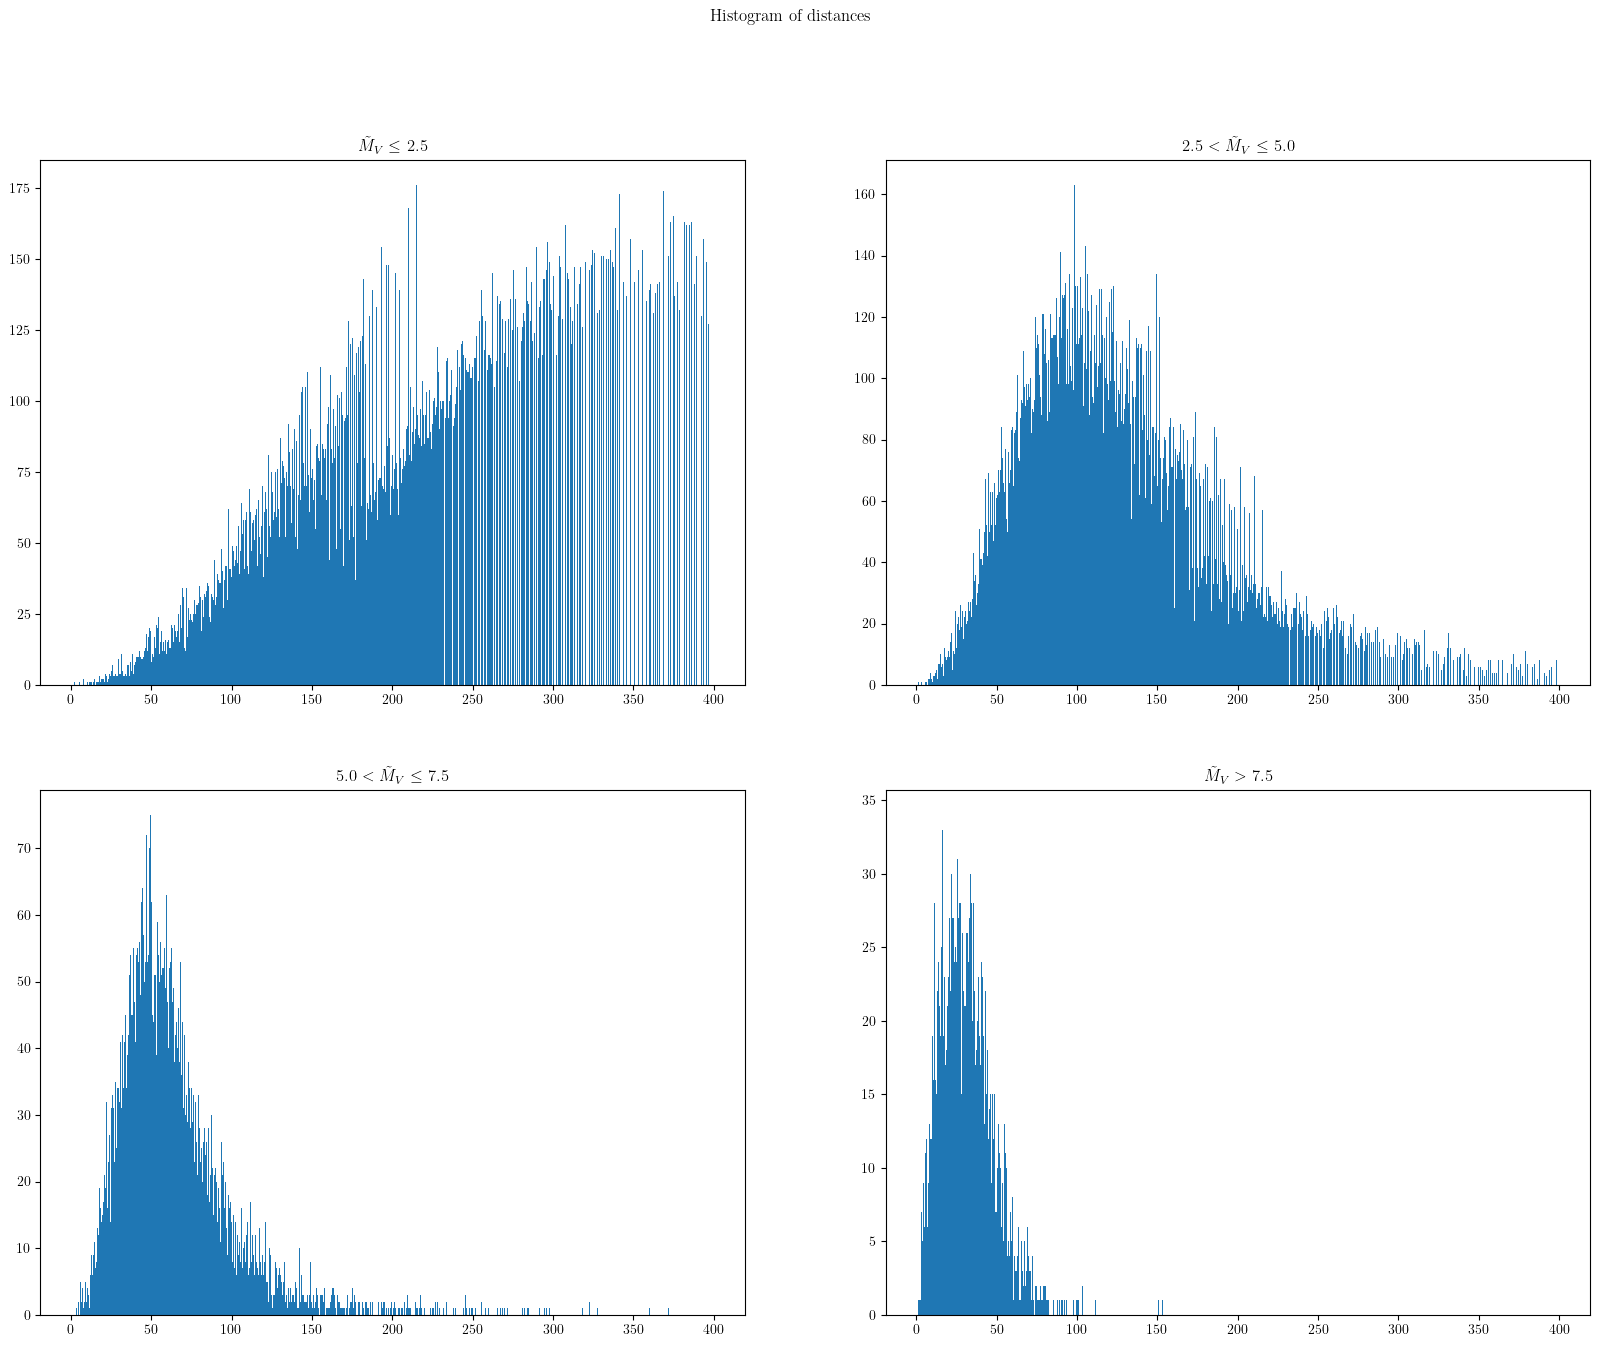

In [66]:
fig,ax = plt.subplots(2,2, figsize=(20,15))
ax1, ax2 = ax[0]
ax3, ax4 = ax[1]
fig.suptitle("Histogram of distances")

quads = [2.5,5,7.5]
ax1.hist(data[data["absmag"]<=quads[0]]["Dist"], bins=np.arange(min(data["Dist"]),400,.5))
ax1.set_title(r"$\tilde{M}_V \le$ %.1f"%(quads[0]))
ax2.hist(data[data["absmag"]>quads[0]][data["absmag"]<=quads[1]]["Dist"], bins=np.arange(min(data["Dist"]),400,.5))
ax2.set_title(r"%.1f $< \tilde{M}_V \le$ %.1f"%(quads[0],quads[1]))
ax3.hist(data[data["absmag"]>quads[1]][data["absmag"]<=quads[2]]["Dist"], bins=np.arange(min(data["Dist"]),400,.5))
ax3.set_title(r"%.1f $< \tilde{M}_V \le$ %.1f"%(quads[1],quads[2]))
ax4.hist(data[data["absmag"]>quads[2]]["Dist"], bins=np.arange(min(data["Dist"]),400,.5))
ax4.set_title(r"$\tilde{M}_V >$ %.1f"%(quads[2]))
plt.savefig("dist_hist.png")
plt.show()

C:\Users\Fenton\AppData\Local\Temp\ipykernel_3588\404052246.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ax2.hist(data[data["absmag"]>quads[0]][data["absmag"]<=quads[1]]["e_Plx"], bins=np.arange(hist_min,hist_max,hist_aspect))
C:\Users\Fenton\AppData\Local\Temp\ipykernel_3588\404052246.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ax3.hist(data[data["absmag"]>quads[1]][data["absmag"]<=quads[2]]["e_Plx"], bins=np.arange(hist_min,hist_max,hist_aspect))


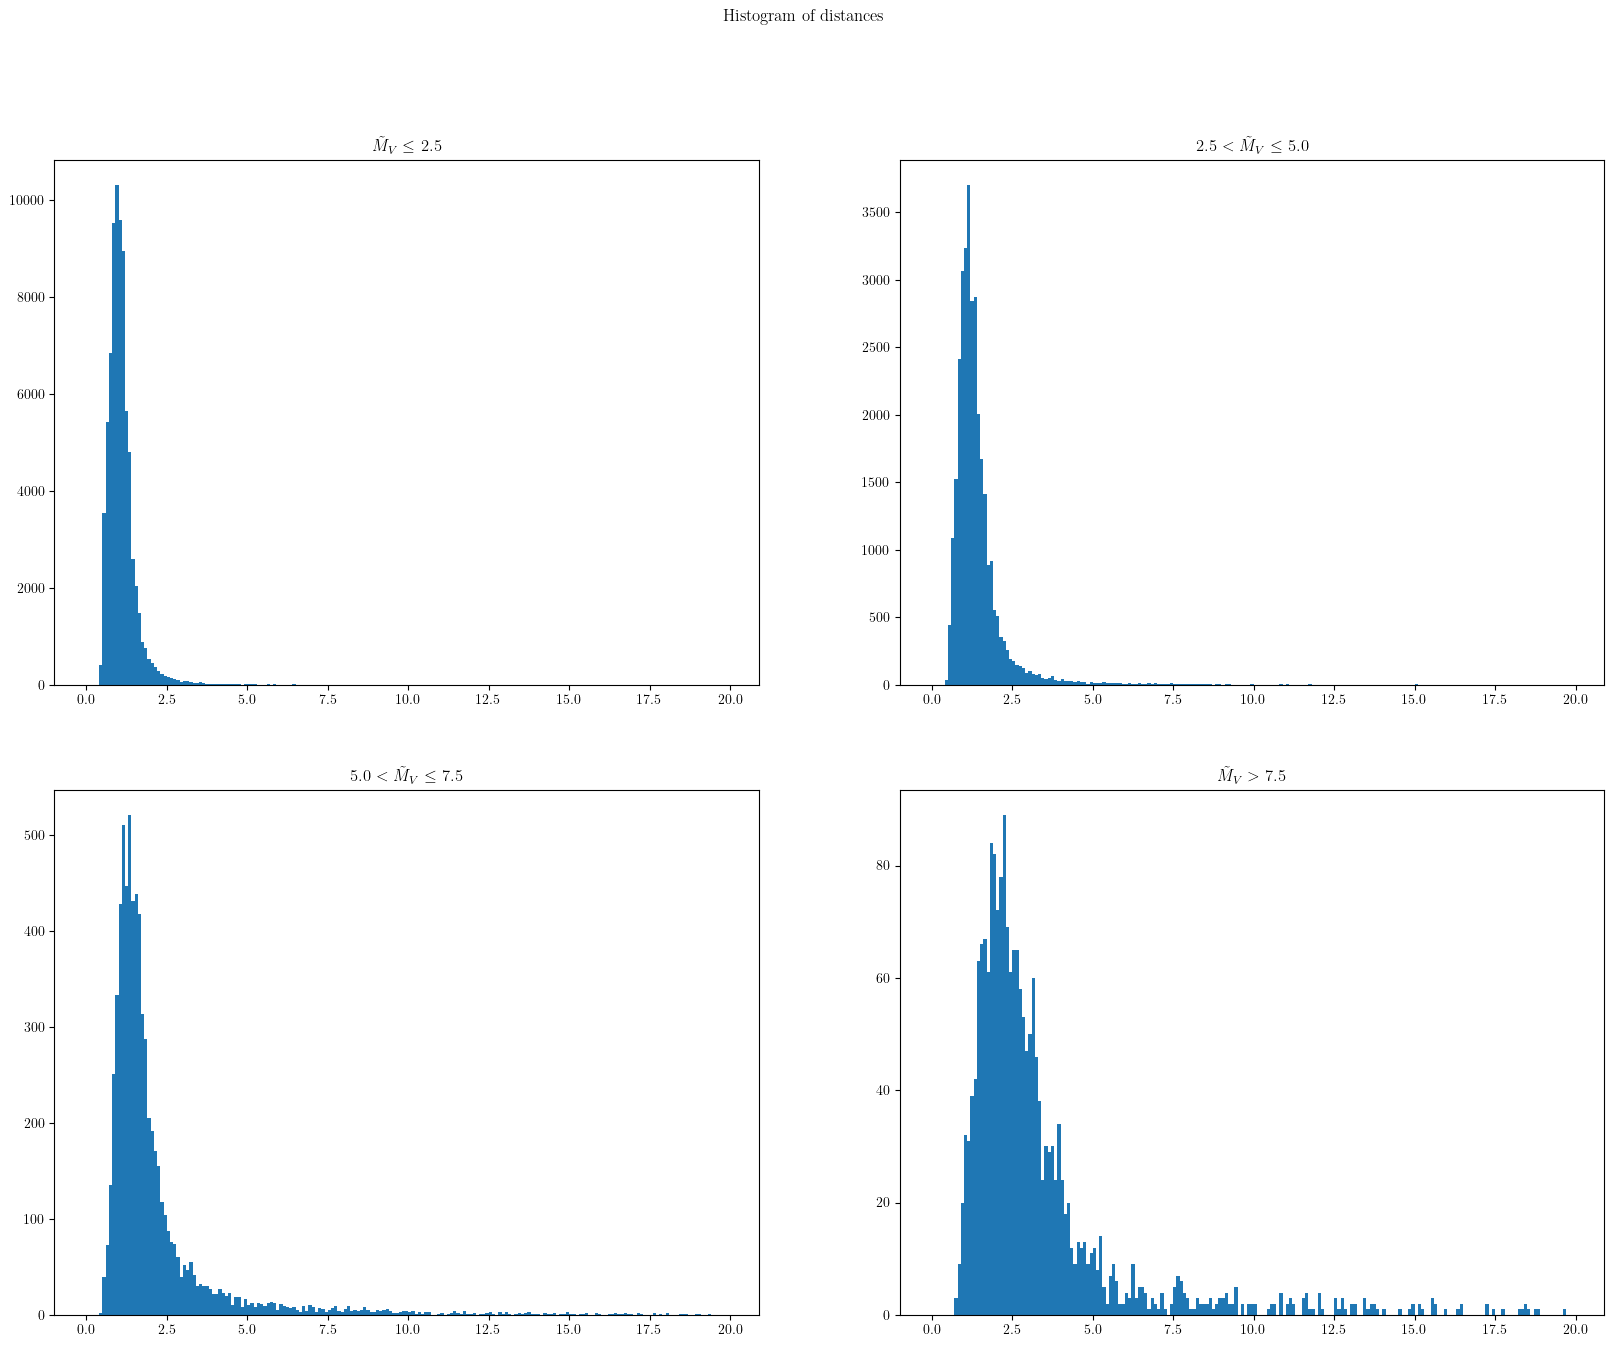

In [70]:
fig,ax = plt.subplots(2,2, figsize=(20,15))
ax1, ax2 = ax[0]
ax3, ax4 = ax[1]
fig.suptitle("Histogram of distances")

hist_min, hist_max = (0,20)
hist_aspect = 0.1

quads = [2.5,5,7.5]
ax1.hist(data[data["absmag"]<=quads[0]]["e_Plx"], bins=np.arange(hist_min,hist_max,hist_aspect))
ax1.set_title(r"$\tilde{M}_V \le$ %.1f"%(quads[0]))
ax2.hist(data[data["absmag"]>quads[0]][data["absmag"]<=quads[1]]["e_Plx"], bins=np.arange(hist_min,hist_max,hist_aspect))
ax2.set_title(r"%.1f $< \tilde{M}_V \le$ %.1f"%(quads[0],quads[1]))
ax3.hist(data[data["absmag"]>quads[1]][data["absmag"]<=quads[2]]["e_Plx"], bins=np.arange(hist_min,hist_max,hist_aspect))
ax3.set_title(r"%.1f $< \tilde{M}_V \le$ %.1f"%(quads[1],quads[2]))
ax4.hist(data[data["absmag"]>quads[2]]["e_Plx"], bins=np.arange(hist_min,hist_max,hist_aspect))
ax4.set_title(r"$\tilde{M}_V >$ %.1f"%(quads[2]))
plt.savefig("e_Plx_hist.png")
plt.show()

In [ ]:
print(min(data["Dist"]),max(data["Dist"]))

# Statistics to do:
- list different star parameters (we have them in the Vizier/Readme.txt, go through and understand them all)
- use statistical methods to quantify how strongly different parameters correlate with one another
- divide up stars by longitudinal quadrants and compare the contents of each quadrant. How do the populations compare? Perform t-test (generate hypothesis)
- obvious selection bias for stars closer to us - compare how population changes with distance from Sol